### Imports

In [39]:
from Bio.PDB import MMCIF2Dict
import pandas as pd
import json
import requests
from pandas.io.json import json_normalize
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')


pd.options.display.max_seq_items = 2000
# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

colors = sb.cubehelix_palette(5, start=.2, rot=-.7, light=.97)
cmap = sb.cubehelix_palette(5, start=.5, rot=-.7, light=.97, as_cmap=True)


sb.set(context='paper', style='darkgrid', rc={
       'figure.facecolor': 'white'}, font_scale=1.2)

pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_seq_items = 2000
# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Set default font size
# Set default font size
plt.rcParams['font.size'] = 24
# Set default font size
sb.set(font_scale=.8)
custom_style = {'axes.labelcolor': 'black',
                'xtick.color': 'black',
                'ytick.color': 'black'}
sb.set_style("white", rc=custom_style)


def url_response(url):
    r = requests.get(url=url)
    if r.status_code == 200:
        json_result = r.json()
        return json_result
    else:
        return None


df3 = pd.read_csv("data/tables/ALL_structures_tab", sep="\t")

###  Context

Different structures of the same protein are often related through conformational changes. Can we estimate what proportion rotamer state substitutions we observe is due to conformational changes and thermodynamic instability rather than protein evolution? We address this issue by studying the conservation of rotamer configurations in a database of proteins with exactly the same amino acid sequence, as a function of structural similarity (RMSD), solvent accessibility, binding status and structure quality.
Our dataset consists of all human Thrombin heavy chain (H) structures available from [Uniprot](https://www.uniprot.org/uniprot/P00734). All of these structures correspond to the same amino acid sequence.

In [3]:
frames = []
# For each PDB_id alignment get info about corresponding PDB entities
entry_search_url = 'http://www.ebi.ac.uk/pdbe/api/pdb/entry/molecules/'
for pdb_id, entity_id in df3[['PDB ID', 'Entity ID']].values:
    entity_id = str(entity_id)
    search_url = entry_search_url + pdb_id.upper()
    r = url_response(search_url)
    if r != None:
        for molecule in r[pdb_id.lower()]:
            # filter for polypeptides
            if entity_id == str(molecule.get("entity_id")) and "polypeptide" in molecule.get('molecule_type'):
                df = json_normalize(molecule)
                df["PDB_id"] = [pdb_id] * len(df)
                frames.append(df)
mol_info_df = pd.concat(frames)
mol_info_df = mol_info_df[['PDB_id'] +
                          [c for c in mol_info_df.columns if c != "PDB_id"]]
mol_info_df["expression_host_scientific_name"] = mol_info_df.source.apply(
    lambda x: x[0]["expression_host_scientific_name"])
print(mol_info_df.shape)

(284, 18)


We collect 284 human Thrombin heavy chain structures with resolution <3.5A.

### Filter sequences

In [4]:
mol_info_df.length.value_counts()

259    240
257     26
258     18
Name: length, dtype: int64

In [5]:
mol_info_df.columns

Index(['PDB_id', 'entity_id', 'mutation_flag', 'synonym', 'weight', 'sequence',
       'molecule_name', 'pdb_sequence', 'ca_p_only', 'source', 'length',
       'in_chains', 'molecule_type', 'in_struct_asyms', 'sample_preparation',
       'gene_name', 'number_of_copies', 'expression_host_scientific_name'],
      dtype='object')

In [6]:
alignment_df = mol_info_df.pdb_sequence.str.split("", expand = True) 
alignment_df.index = mol_info_df.PDB_id.values
alignment_df

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17   \
1A2C       I   V   E   G   S   D   A   E   I   G   M   S   P   W   Q   V   M   
1A3B       I   V   E   G   S   D   A   E   I   G   M   S   P   W   Q   V   M   
1A3E       I   V   E   G   S   D   A   E   I   G   M   S   P   W   Q   V   M   
1A46       I   V   E   G   S   D   A   E   I   G   M   S   P   W   Q   V   M   
1A4W       I   V   E   G   S   D   A   E   I   G   M   S   P   W   Q   V   M   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
6EO7       I   V   E   G   S   D   A   E   I   G   M   S   P   W   Q   V   M   
6EO8       I   V   E   G   S   D   A   E   I   G   M   S   P   W   Q   V   M   
6EO9       I   V   E   G   S   D   A   E   I   G   M   S   P   W   Q   V   M   
7KME       I   V   E   G   S   D   A   E   I   G   M   S   P   W   Q   V   M   
8KME       I   V   E   G   S   D   A   E   I   G   M   S   P   W   Q   V   M   

     18  19  20  21  22  23  24  25  26  27  28  29   ... 231 232 233 234 235  \
1A2C   L   F   R   K   S   P   Q   E   L   L   C   G  ...   C   D   R   D   G   
1A3B   L   F   R   K   S   P   Q   E   L   L   C   G  ...   C   D   R   D   G   
1A3E   L   F   R   K   S   P   Q   E   L   L   C   G  ...   C   D   R   D   G   
1A46   L   F   R   K   S   P   Q   E   L   L   C   G  ...   C   D   R   D   G   
1A4W   L   F   R   K   S   P   Q   E   L   L   C   G  ...   C   D   R   D   G   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..   
6EO7   L   F   R   K   S   P   Q   E   L   L   C   G  ...   C   D   R   D   G   
6EO8   L   F   R   K   S   P   Q   E   L   L   C   G  ...   C   D   R   D   G   
6EO9   L   F   R   K   S   P   Q   E   L   L   C   G  ...   C   D   R   D   G   
7KME   L   F   R   K   S   P   Q   E   L   L   C   G  ...   C   D   R   D   G   
8KME   L   F   R   K   S   P   Q   E   L   L   C   G  ...   C   D   R   D   G   

     236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253  \
1A2C   K   Y   G   F   Y   T   H   V   F   R   L   K   K   W   I   Q   K   V   
1A3B   K   Y   G   F   Y   T   H   V   F   R   L   K   K   W   I   Q   K   V   
1A3E   K   Y   G   F   Y   T   H   V   F   R   L   K   K   W   I   Q   K   V   
1A46   K   Y   G   F   Y   T   H   V   F   R   L   K   K   W   I   Q   K   V   
1A4W   K   Y   G   F   Y   T   H   V   F   R   L   K   K   W   I   Q   K   V   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
6EO7   K   Y   G   F   Y   T   H   V   F   R   L   K   K   W   I   Q   K   V   
6EO8   K   Y   G   F   Y   T   H   V   F   R   L   K   K   W   I   Q   K   V   
6EO9   K   Y   G   F   Y   T   H   V   F   R   L   K   K   W   I   Q   K   V   
7KME   K   Y   G   F   Y   T   H   V   F   R   L   K   K   W   I   Q   K   V   
8KME   K   Y   G   F   Y   T   H   V   F   R   L   K   K   W   I   Q   K   V   

     254 255 256 257 258 259 260  
1A2C   I   D   Q   F   G   E      
1A3B   I   D   Q   F   G   E      
1A3E   I   D   Q   F   G   E      
1A46   I   D   Q   F   G   E      
1A4W   I   D   Q   F   G   E      
...   ..  ..  ..  ..  ..  ..  ..  
6EO7   I   D   Q   F   G   E      
6EO8   I   D   Q   F   G   E      
6EO9   I   D   Q   F   G   E      
7KME   I   D   Q   F   G   E      
8KME   I   D   Q   F   G   E      

[284 rows x 261 columns]

In [7]:
sitewise_AA_identity = alignment_df.apply(lambda c : c.value_counts()[0] / len(alignment_df) * 100, axis=0)
len(sitewise_AA_identity[sitewise_AA_identity == 100])

258

In [8]:
# drop alignment columns that don't have 100% AA sequence identity
alignment_df_filtered  = alignment_df[sitewise_AA_identity[sitewise_AA_identity == 100].index.tolist()]
# replace sequences with filtered sequences
alignment_df_filtered.apply(lambda x: "".join(x), axis=1)[0]

'IVEGSDAEIGMSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLLYPPWDKNFTENDLLVRIGKHSRTRYERNIEKISMLEKIYIHPRYNWRENLDRDIALMKLKKPVAFSDYIHPVCLPDRETAASLLQAGYKGRVTGWGNLKETWTANVGKGQPSVLQVVNLPIVERPVCKDSTRIRITDNMFCAGYKPDEGKRGDACEGDSGGPFVMKSPFNNRWYQMGIVSWGEGCDRDGKYGFYTHVFRLKKWIQKVIDQF'

These sequences share the same 258AA-long sequence.

### Structure metadata

In [9]:
expression_host = mol_info_df["expression_host_scientific_name"].replace(' BL21\(DE3\)', '', regex=True)
expression_host_counts = expression_host.value_counts()
expression_host_counts

Escherichia coli      13
Cricetulus griseus     7
Homo sapiens           2
Mus musculus           2
Name: expression_host_scientific_name, dtype: int64

In [10]:
sample_preparation = mol_info_df.sample_preparation.astype(str).replace(
    regex=True, to_replace=" ", value="\n").replace(
    regex=True, to_replace="Genetically\nmanipulated", value="Recombinant")
sample_preparation_counts = sample_preparation.value_counts()
sample_preparation_counts #Recombinant

Natural\nsource    231
Recombinant         53
Name: sample_preparation, dtype: int64

In [11]:
#https://www.ebi.ac.uk/pdbe/api/pdb/entry/experiment/:pdbid
#This call provides details of experiment(s) carried out in determining the structure of
#the entry. For X-ray diffraction, the description consists of resolution, spacegroup,
#cell dimensions, R and Rfree, refinement program, etc.

frames = []
# For each PDB_id in get experiment quality info about corresponding PDB entities
entry_search_url = 'https://www.ebi.ac.uk/pdbe/api/pdb/entry/experiment/'
for pdb_id, entity_id in df3[['PDB ID', 'Entity ID']].values:
    entity_id = str(entity_id)
    search_url = entry_search_url + pdb_id.upper()
    r = url_response(search_url)
    if r != None:
        for data in r[pdb_id.lower()]:
            df = json_normalize(data)
            df["PDB_id"] = [pdb_id] * len(df)
            frames.append(df)
exp_info_df = pd.concat(frames)
#print(exp_info_df.columns)
#exp_info_df = exp_info_df[['PDB_id', 'cell.a', 'cell.b', 'cell.c',
#                          'r_factor', 'resolution']]
exp_info_df["cell_size"] = exp_info_df['cell.a'] * exp_info_df['cell.b'] * exp_info_df['cell.c']
exp_info_df.head()

resolution_low  starting_model r_free_selection_details  resolution_high  \
0              7  PDB ENTRY 1HGT                     None           2.1000   
0             20            None                     None           1.8000   
0             20  PDB ENTRY 1HGT                     None           1.8500   
0              7  PDB ENTRY 1HAH                     None           2.1200   
0              7  PDB ENTRY 1FPC                     None           1.8000   

  r_free_percent_reflections r_factor r_free       refinement_software  \
0                       None   0.1500   None                      None   
0                          5   0.1700 0.2300                      None   
0                          5   0.1700 0.2200                      None   
0                       None   0.1550   None  PROFFT                     
0                       None   0.1550   None  PROFFT                     

  completeness percent_reflections_observed  \
0         None                           70   
0         None                      99.2000   
0         None                      98.4000   
0      77.2600                           75   
0      60.1700                           65   

                              diffraction_experiment  \
0  [{'wavelength_list': None, 'detector_details':...   
0  [{'wavelength_list': None, 'detector_details':...   
0  [{'wavelength_list': None, 'detector_details':...   
0  [{'wavelength_list': None, 'detector_details':...   
0  [{'wavelength_list': None, 'detector_details':...   

               expression_host_scientific_name  \
0  [{'scientific_name': None, 'tax_id': None}]   
0                                           []   
0                                           []   
0                                           []   
0  [{'scientific_name': None, 'tax_id': None}]   

                                      crystal_growth experimental_method  \
0  [{'grow_details': 'pH 7.3', 'grow_ph': 7.3, 'g...   X-ray diffraction   
0  [{'grow_details': '20% PEG 8000, 0.05 M SODIUM...   X-ray diffraction   
0  [{'grow_details': '20% PEG 8000, 0.05M SODIUM ...   X-ray diffraction   
0  [{'grow_details': '0.1 M SODIUM PHOSPHATE BUFF...   X-ray diffraction   
0  [{'grow_details': '0.1 M SODIUM PHOSPHATE BUFF...   X-ray diffraction   

  num_reflections phasing_method experiment_data_available  \
0            None           None                      None   
0            None           None                      None   
0            None           None                      None   
0           16189           None                         Y   
0           20391           None                         Y   

  experimental_method_class r_work spacegroup  resolution  \
0                     x-ray 0.1500    C 1 2 1      2.1000   
0                     x-ray 0.1700    C 1 2 1      1.8000   
0                     x-ray 0.1700    C 1 2 1      1.8500   
0                     x-ray 0.1550    C 1 2 1      2.1200   
0                     x-ray 0.1550    C 1 2 1      1.8000   

  structure_determination_method  cell.a  cell.c  cell.b  cell.beta  \
0          MOLECULAR REPLACEMENT 71.9700 72.2400 72.4800   100.9300   
0          MOLECULAR REPLACEMENT 70.1500 71.6500 71.3400   100.2300   
0          MOLECULAR REPLACEMENT 71.2040 73.0120 72.0410   100.9300   
0          MOLECULAR REPLACEMENT 71.3000 73.8200 73.0900   101.1200   
0          MOLECULAR REPLACEMENT 71.4700 73.3900 72.0000   101.1300   

   cell.alpha  cell.gamma PDB_id    cell_size  
0     90.0000     90.0000   1A2C 376,831.6957  
0     90.0000     90.0000   1A3B 358,572.4967  
0     90.0000     90.0000   1A3E 374,522.8929  
0     90.0000     90.0000   1A46 384,699.4209  
0     90.0000     90.0000   1A4W 377,653.1976

In [12]:
regexes = [r'DIFFERENCE FOURIER PLUS REFINEMENT',
           r'THE STRUCTURE WAS ANALYZED BY DIFFERENCE FOURIER TECHNIQUES',
           r'DIFFERENCE FOURIER', r'FOURIER SYNTHESIS']

structure_determination_method = exp_info_df.structure_determination_method.astype(
    str).apply(lambda x: x.rstrip()).replace(
    regex=True, to_replace=regexes, value=r'Fourier synthesis').apply(lambda x: x.lower().title()).replace(
    regex=True, to_replace='Fourier ', value='Fourier\n').replace(
    regex=True, to_replace='Ab Initio Phasing', value='Ab Initio').replace(
    regex=True, to_replace='Mad', value='MAD').replace(
    regex=True, to_replace='Molecular Replacement', value='Molecular\nReplacement')
structure_determination_method.value_counts()

Molecular\nReplacement    157
None                       69
Fourier\nSynthesis         33
Other                      19
Ab Initio                   5
MAD                         1
Name: structure_determination_method, dtype: int64

In [13]:
regexes = [r'\(PHENIX.REFINE: ', r'\)$', r'_\d*$',
          r'\(PHENIX.REFINE', r'\.0019.*$', r'-']
# remove trailing spaces 
refinement_software = exp_info_df.refinement_software.astype(
    str).apply(lambda x: x.rstrip())
# clean up category names
refinement_software.replace(
    regex=True, inplace=True, to_replace=regexes, value=r'')
refinement_software = refinement_software.apply(lambda x:x.split(" ")[0].title())
refinement_software_counts = refinement_software.value_counts()
refinement_software_counts.head(10)

None        130
Refmac       38
Shelxl97     37
Phenix       30
Xplor        17
Cns          13
Buster        7
Cnx           4
Tnt           4
Profft        3
Name: refinement_software, dtype: int64

In [14]:
list(exp_info_df.diffraction_experiment.values[0][0].keys())

['wavelength_list',
 'detector_details',
 'beam_source_type',
 'detector_type',
 'synchrotron_beamline',
 'source_details',
 'synchrotron_site',
 'diffraction_protocol',
 'ambient_temp',
 'wavelength',
 'detector',
 'beam_source_name']

In [15]:
synchrotron_site = exp_info_df.diffraction_experiment.apply(
    lambda x: x[0]["synchrotron_site"])
synchrotron_site = synchrotron_site.astype(str).apply(lambda x:x.split(" ")[0])
synchrotron_site_counts = synchrotron_site.value_counts()
synchrotron_site_counts.head(10)

None       182
BESSY       39
SLS         19
ESRF        14
PETRA        5
APS          5
Diamond      4
SRS          4
ELETTRA      3
SSRL         2
Name: diffraction_experiment, dtype: int64

In [16]:
#The mean temperature in kelvins at which the intensities were measured.
ambient_temp = exp_info_df.diffraction_experiment.apply(
    lambda x: x[0]["ambient_temp"])
# convert Fahrenheit and Kelvin to Celsius
ambient_temp = ambient_temp.apply(lambda t: (t - 32) / 1.8 if t < 200 else t - 273.15)
ambient_temp = ambient_temp.apply(lambda x: f"{x:.2f}")
ambient_temp_counts = ambient_temp.value_counts()
ambient_temp_counts.head(10)

37.78    113
nan       56
43.33     25
24.85     22
45.00     15
16.85      9
26.85      7
21.85      6
19.85      5
41.67      4
Name: diffraction_experiment, dtype: int64

In [17]:
# The detector type used for recording images. Usually film or CCD camera.
detector_type = exp_info_df.diffraction_experiment.apply(
    lambda x: x[0]["detector_type"]).astype(str).apply(lambda x: " ".join(x.split(" ")[:2]).title())
detector_type_counts = detector_type.value_counts()
detector_type_counts.head(10)

Rigaku Raxis       57
None               52
Marmosaic 225      24
Marresearch        19
Adsc Quantum       17
Dectris Pilatus    16
Mar Ccd            15
Rayonix Mx-225     13
Rigaku             12
Siemens            11
Name: diffraction_experiment, dtype: int64

In [18]:
# The radiation wavelength in angstroms (Å).
wavelength = exp_info_df.diffraction_experiment.apply(
    lambda x: x[0]["wavelength"]).apply(lambda x: f"{x:.3f}")
wavelength_counts = wavelength.value_counts()
wavelength_counts.head(10)

1.542    116
nan       47
0.918     34
1.000     20
1.540     19
0.979      6
0.976      6
0.980      4
0.934      4
0.978      3
Name: diffraction_experiment, dtype: int64

In [19]:
# The pH at which the crystal was grown.
grow_ph = exp_info_df.crystal_growth.apply(
    lambda x: x[0]["grow_ph"]).apply(lambda x: f"{x:.1f}")
grow_ph_counts = grow_ph.value_counts()
grow_ph_counts.head(10)

nan    88
7.5    87
7.3    25
7.0    22
8.5    14
7.4    10
7.2     6
5.6     5
6.5     4
8.2     3
Name: crystal_growth, dtype: int64

In [20]:
# The method used to grow the crystals.
grow_method = exp_info_df.crystal_growth.apply(
    lambda x: x[0]["grow_method"]).dropna().astype(str).apply(lambda x: x.lower()).replace(
    regex=True, to_replace=",", value=",\n")
grow_method_counts = grow_method.value_counts()
grow_method_counts.head(10)

vapor diffusion,\n hanging drop    92
vapor diffusion,\n sitting drop    27
vapor diffusion                    14
evaporation                         1
macro seeding                       1
Name: crystal_growth, dtype: int64

In [21]:
# grow_temperature
grow_temperature = exp_info_df.crystal_growth.apply(
    lambda x: x[0]["grow_temperature"]).apply(lambda x: f"{x:.1f}")
grow_temperature_counts = grow_temperature.value_counts()
grow_temperature_counts.head(10)

nan      151
277.0     53
277.1     24
298.0     22
293.0     20
291.0      6
295.0      3
281.0      2
290.0      1
278.0      1
Name: crystal_growth, dtype: int64

In [22]:
# https://www.ebi.ac.uk/pdbe/api/pdb/entry/ligand_monomers/:pdbid
# This call provides a a list of modelled instances of ligands,
# i.e. 'bound' molecules that are not waters.
frames = []
entry_search_url = 'https://www.ebi.ac.uk/pdbe/api/pdb/entry/ligand_monomers/'
for pdb_id, entity_id in df3[['PDB ID', 'Entity ID']].values:
    entity_id = str(entity_id)
    search_url = entry_search_url + pdb_id.upper()
    r = url_response(search_url)
    if r != None:
        for data in r[pdb_id.lower()]:
            df = json_normalize(data)
            df["PDB_id"] = [pdb_id] * len(df)
            frames.append(df)
ligands_df = pd.concat(frames)
ligands_df = ligands_df[["PDB_id", "chem_comp_name"]]

# N-Acetylglucosamine
ligands = ligands_df.chem_comp_name.apply(lambda x: x.rstrip().title()).replace(to_replace="N-Acetyl-D-Glucosamine",
                                                                      value="N-Acetylglucosamine", 
                                                                      regex=True).replace(
    to_replace="D-Phenylalanyl-N-.*$", value="0G6", regex=True)

ligands_counts = ligands.value_counts()
ligands_counts.head(10)

Sodium Ion             287
N-Acetylglucosamine    127
Glycerol                85
0G6                     58
Phosphate Ion           42
Dimethyl Sulfoxide      39
Calcium Ion             18
Zinc Ion                15
Chloride Ion            12
Benzamidine             11
Name: chem_comp_name, dtype: int64

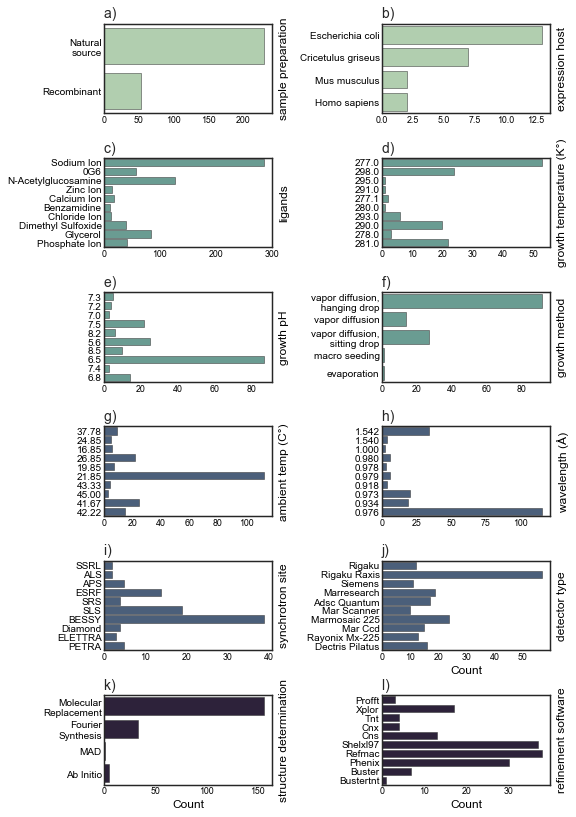

In [60]:
series = [sample_preparation, expression_host, ligands,
          grow_temperature, grow_ph, grow_method,
          ambient_temp, wavelength, synchrotron_site,
          detector_type, structure_determination_method, refinement_software]

# clean subplot labels
preparation_labels = ["sample preparation", "expression host"]
crystallisation_labels = [
    "ligands", "growth temperature (K°)", "growth pH", "growth method"]
acquisition_labels = ["ambient temp (C°)", "wavelength (Å)", "synchrotron site",
                      "detector type"]
modelling_labels = ["structure determination", "refinement software"]

labels = preparation_labels + crystallisation_labels + \
    acquisition_labels + modelling_labels


# panel labels
panel_labels = [f"{s})  " for s in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i',
                                         'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's',
                                         't', 'u', 'v', 'w', 'x', 'y', 'z']]


# merge into a single dataset for countplots
feat_arr = []
cat_arr = []
for s, l in zip(series, labels):
    feat_arr.extend([l] * len(s))
    cat_arr.extend(s.tolist())
data_dict = {"feature": feat_arr,
             "value": cat_arr}
plot_data = pd.DataFrame(data_dict)
# custom sort categories
plot_data["feature"] = pd.Categorical(plot_data["feature"], labels)
plot_data.sort_values("feature")
# clean up values
plot_data["value"] = plot_data["value"].astype(str).apply(lambda x: x.rstrip())

# create grid
fig, axes = plt.subplots(ncols=2, nrows=6, figsize=(8, 14))
fig.subplots_adjust(wspace=.65, hspace=.5)
flat_axes = axes.flatten()

# one color per feature group
colors = sb.cubehelix_palette(5, start=.5, rot=-.7, light=.97)[1:]
#colors = sb.color_palette("husl", 4)
color_list = [colors[0]]*len(preparation_labels) + \
    [colors[1]]*len(crystallisation_labels) + \
    [colors[2]]*len(acquisition_labels) + \
    [colors[3]]*len(modelling_labels)
color_dict = dict(zip(labels, color_list))

i=0
for name, group in plot_data.groupby(by='feature'):
    to_replace = ['nan', 'None', 'none', 'Other']
    group["value"] = group["value"].replace(to_replace, np.nan)
    group = group.dropna()

    # keep only 10 most frequent values
    group_top_10 = group["value"].value_counts().head(10).index.tolist()
    group = group[group.value.isin(group_top_10)]

    # get the axis
    ax = flat_axes[i]
    # get the color
    c = color_dict[name]
    # plot countplot
    sb.countplot(y="value",
                 linewidth=.5,
                 edgecolor=".2",
                 color=c, 
                 data=group, 
                 ax=ax)

    ax.tick_params(axis='both', which='major', length=.0, pad=2.2)
    labels = group.value.unique()
    ax.set_yticklabels(labels, rotation="horizontal", ha="right", fontsize=10)
    # set panel label
    ax.set_title(panel_labels[i], loc="left", fontsize=14)
    ax.set_ylabel("")
    ax.set_xlabel("")

    # put y label on left spine
    ax2 = ax.twinx()
    ax2.tick_params(axis='both', which='major', length=.0, pad=2.6)
    ax2.set_ylabel(name, fontsize=12)
    ax2.set_yticklabels([])

    # label x axis in bottom row
    if i > 8:
        ax.set_xlabel("Count", fontsize=12)
    i += 1

# for ax in flat_axes[-1:]:
#    ax.set_visible(False)

plt.show()

fig.savefig("figures/structure_metadata_barplot.pdf", format='pdf',
            bbox_inches='tight', dpi=fig.dpi)

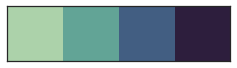

In [24]:
sb.palplot(sb.cubehelix_palette(5, start=.5, rot=-.7, light=.97)[1:])

The first prerequisite of structure determination is to produce and purify a sufficient quantity of the protein of interest.
Protein production is typically achieved by expressing a recombinant gene coding for the peptide of interest in a host organism (graslund2008protein). Recombinant human Prothrombin can be produced in E.coli as a single, non-glycosylated polypeptide chain, since bacteria lack the required post-translational machinery (rosano2014recombinant).  This issue can be particularly problematic for multi-domain eukaryotic proteins expressed in bacteria, which often are non-functional and can be difficult to purify. Expressions systems using mammalian cells and organisms (e.g. small rodents) have been developed for applications requiring accurate folding, however, these systems have lower yields than bacteria, as well as other limitations (e.g. time-consuming, toxicity to host cells) (graslund2008protein). In the case of Thrombin, it is also possible to purify the protein directly from human plasma.

The following step in structure determination requires obtaining crystals from the purified protein of interest, with a volume suitable (i.e. 0.1–0.4 mm in each dimension) for X-ray analysis. The extent and resolution of the X-ray diffraction pattern from a crystal correlates with its degree of internal order: the more structurally uniform are the molecules in the crystal and  the more precise is their periodic arrangement, the larger, more uniform, and more defined is the scattering pattern. 

In the process of protein crystallization, proteins are dissolved in an aqueous solution that is supersaturated in the macromolecule (i.e. the protein is present in excess of its solubility limit) but exhibits conditions that do not significantly perturb the protein's native state (cite mcpherson2004introduction). Supersaturation is achived via addition of precipitating agents (e.g. neutral salts, polymers), and by the manipulation of various parameters which influence the number and volume of obtained crystals, including temperature, ionic strength and pH. Once supersaturation is reached, nucleation and growth of crystals favors the re-establishment of equilibrium (cite rhodes2010crystallography). 

Other factors that can affect the structural state of the macromolecule include metal ions, inhibitors, cofactors or other small molecules.

A variety of crystal growth strategies have been developed among which the most common is vapor diffusion (cite rhodes2010crystallography). In this method, droplets containing purified protein, buffer, and precipitant are allowed to equilibrate with a larger reservoir containing similar buffers and precipitants in higher concentrations. Vapor diffusion can be performed in either hanging-drop or sitting-drop format. Hanging-drop involves placing a drop of protein solution on an inverted cover slip suspended above the reservoir. Sitting-drop places the drop on a pedestal separated from the reservoir. In both cases crystal growth occurs in the drop.

Even under the same crystallization conditions, a marked variation in crystal properties exists (cite rhodes2010crystallography). For each individual protein, crystallization is a matter of finding and optimizing a set of parameerst that yield the best crystals possible.

Once a crystal is obtained, it is placed in an intense beam of X-rays, usually of a single wavelength around 1 Å which is on the scale of covalent chemical bonds and the ratomic radius. X-ray beams are generated in synchrotrons, which accelerate charged particles and confine them in a circular loop using magnetic fields. Most synchrotrons are national facilities, such as BESSY II in Berlin, the Swiss Light Source (SLS), and the Canadian Light Source (CLS). Each has several dedicated beamlines where samples are rotated whithin the X-ray beam, producing a regular pattern of reflections at each position. The intensities of these reflections can be recorded with an image plate (e.g. Rigaku's R-AXIS detectors), or with a charge-coupled device (CCD) camera (e.g. mars/Rayonix detectors).  

The recorded dataset of two-dimensional diffraction patterns is converted into a three-dimensional electron density map. To do so both amplitude and phase must be determined (cite taylor2003phase). The latter cannot be directly measured during a diffraction experiment and has to be estimated through a variety of approaches including: 1) ab initio phasing which exploits known phase relationships between certain groups of reflections, 2) molecular replacement where a known related strucure is used to determine the orientation and position of the molecules within the unit cell, and 3) multi-wavelength anomalous diffraction (MAD) phasing in which methionines are replaced with seleno-methionines and reflections are recoorded at three different wavelengths thus altering the selenium atom scattering in a known way yielding the position of any methionine residues within the protein (cite hendrickson1985analysis).

Having obtained initial phases, a preliminary electron density can be obtained by Fourier synthesis (cite taylor2003phase). The atomic positions in the model and their B-factors can be then refined to fit the observed diffraction data, and successive rounds of refinement are carried out (cite rhodes2010crystallography). These steps are performed using computational methods that compare the experimental data to the simulated diffractogram of a model structure, taking into account the instrumental parameters, and refine the structural parameters of the model using least-squares based minimization algorithm. Widely-used refinement software include SHELXL (sheldrick2015crystal), REFMAC (murshudov2011refmac5), and PHENIX (liebschner2019macromolecular).

This interative process continues until the correlation between the diffraction data and the model is maximized. The agreement is measured by an R-factor which measures how well the refined structure predicts the observed data.

The **R-factor** it is a measure of how well the refined structure predicts the observed data
For large molecules, the R-factor usually **ranges between 0.6** (when computed for a random
model and against an experimental data set) **and 0.2** (for example for a well refined 
macro-molecular model at a resolution of 2.5 Ångström).

The **unit cell** is the smallest divisible unit of a mineral that possesses the symmetry and properties of the mineral. The unit cell is repeated by simple translations to make up the 
crystal. The cell is defined by **three axes** or cell edges, termed **a**, **b**, and **c** and three inter-axial angles alpha, beta, and gamma, such that alpha is the angle between b and c, beta between a and c, and gamma between a and b.
**The larger the unit cell, the more diffracted beams (called ‘reflections’) can be observed** 
(PMID:18034855).

Other factors that can affect the structural state of the macromolecule include metal ions, inhibitors, cofactors or other small molecules.


Although the presence of extensive solvent regions is a major contributor to the generally modest diffraction quality of protein crystals, it is also responsible for their value to biochemists. Because of the high solvent content, the individual macromolecules in protein crystals are surrounded by layers of water that maintain their structure virtually unchanged from that found in solution. As a consequence, ligand binding, enzymatic, spectroscopic characteristics and most other biochemical features are essentially the same as for the fully solvated molecule. Conventional chemical compounds, which may be ions, ligands, substrates, coenzymes, inhibitors, drugs or other effector molecules, may be freely diffused into and out of the crystals.

- N-ACETYL-D-GLUCOSAMINE is a prothrombotic used to accelerate thrombin formation via factor XIIa activation  
- GLYCEROL is used s a cryosolvent in cryocrystallography and to control of equilibration by vapor diffusio
- DIMETHYL SULFOXIDE (DMSO) is used as a solvent for hydrophobic compounds

In [25]:
exp_info_df.head()

resolution_low  starting_model r_free_selection_details  resolution_high  \
0              7  PDB ENTRY 1HGT                     None           2.1000   
0             20            None                     None           1.8000   
0             20  PDB ENTRY 1HGT                     None           1.8500   
0              7  PDB ENTRY 1HAH                     None           2.1200   
0              7  PDB ENTRY 1FPC                     None           1.8000   

  r_free_percent_reflections r_factor r_free       refinement_software  \
0                       None   0.1500   None                      None   
0                          5   0.1700 0.2300                      None   
0                          5   0.1700 0.2200                      None   
0                       None   0.1550   None  PROFFT                     
0                       None   0.1550   None  PROFFT                     

  completeness percent_reflections_observed  \
0         None                           70   
0         None                      99.2000   
0         None                      98.4000   
0      77.2600                           75   
0      60.1700                           65   

                              diffraction_experiment  \
0  [{'wavelength_list': None, 'detector_details':...   
0  [{'wavelength_list': None, 'detector_details':...   
0  [{'wavelength_list': None, 'detector_details':...   
0  [{'wavelength_list': None, 'detector_details':...   
0  [{'wavelength_list': None, 'detector_details':...   

               expression_host_scientific_name  \
0  [{'scientific_name': None, 'tax_id': None}]   
0                                           []   
0                                           []   
0                                           []   
0  [{'scientific_name': None, 'tax_id': None}]   

                                      crystal_growth experimental_method  \
0  [{'grow_details': 'pH 7.3', 'grow_ph': 7.3, 'g...   X-ray diffraction   
0  [{'grow_details': '20% PEG 8000, 0.05 M SODIUM...   X-ray diffraction   
0  [{'grow_details': '20% PEG 8000, 0.05M SODIUM ...   X-ray diffraction   
0  [{'grow_details': '0.1 M SODIUM PHOSPHATE BUFF...   X-ray diffraction   
0  [{'grow_details': '0.1 M SODIUM PHOSPHATE BUFF...   X-ray diffraction   

  num_reflections phasing_method experiment_data_available  \
0            None           None                      None   
0            None           None                      None   
0            None           None                      None   
0           16189           None                         Y   
0           20391           None                         Y   

  experimental_method_class r_work spacegroup  resolution  \
0                     x-ray 0.1500    C 1 2 1      2.1000   
0                     x-ray 0.1700    C 1 2 1      1.8000   
0                     x-ray 0.1700    C 1 2 1      1.8500   
0                     x-ray 0.1550    C 1 2 1      2.1200   
0                     x-ray 0.1550    C 1 2 1      1.8000   

  structure_determination_method  cell.a  cell.c  cell.b  cell.beta  \
0          MOLECULAR REPLACEMENT 71.9700 72.2400 72.4800   100.9300   
0          MOLECULAR REPLACEMENT 70.1500 71.6500 71.3400   100.2300   
0          MOLECULAR REPLACEMENT 71.2040 73.0120 72.0410   100.9300   
0          MOLECULAR REPLACEMENT 71.3000 73.8200 73.0900   101.1200   
0          MOLECULAR REPLACEMENT 71.4700 73.3900 72.0000   101.1300   

   cell.alpha  cell.gamma PDB_id    cell_size  
0     90.0000     90.0000   1A2C 376,831.6957  
0     90.0000     90.0000   1A3B 358,572.4967  
0     90.0000     90.0000   1A3E 374,522.8929  
0     90.0000     90.0000   1A46 384,699.4209  
0     90.0000     90.0000   1A4W 377,653.1976

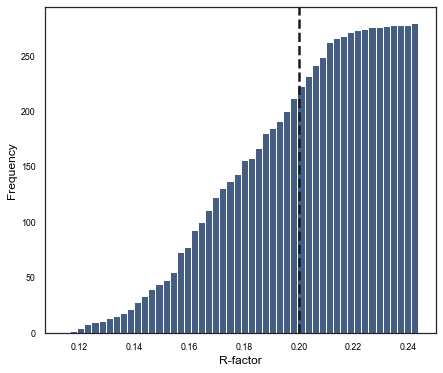

In [61]:
fig, ax = plt.subplots(figsize=(7,6))
colors = sb.cubehelix_palette(5, start=.5, rot=-.7, light=.97)

exp_info_df['r_factor'].hist(bins=50, color=colors[3], 
                             cumulative=True,  
                             ax=ax)
ax.axvline(.2, linestyle="--", linewidth=2.5, color="k", zorder=10)

# Hide grid lines
ax.grid(False)
ax.set_xlabel("R-factor", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
fig.savefig("figures/structure_Rfactor_hist.pdf", format='pdf',
            bbox_inches='tight', dpi=fig.dpi)

The R-factor it is a measure of how well the refined structure predicts the observed data For large molecules, the R-factor usually ranges between 0.6 (when computed for a random model and against an experimental data set) and 0.2 (for example for a well refined macro-molecular model at a resolution of 2.5 Ångström).

The unit cell is the smallest divisible unit of a mineral that possesses the symmetry and properties of the mineral. The unit cell is repeated by simple translations to make up the crystal. The cell is defined by three axes or cell edges, termed a*, *b, and c** and three inter-axial angles alpha, beta, and gamma, such that alpha is the angle between b and c, beta between a and c, and gamma between a and b. **The larger the unit cell, the more diffracted beams (called ‘reflections’) can be observed (PMID:18034855).**


### Structure-wise rotastate variability

Here "variability" is intended as each structure's rotasequence distance from the consensus rotasequence expressed in percentange of rotasequence identity.

In [27]:
# compute each structure's distance (as % rotaseq id) from the consensus rotasequence
sitewise_df = pd.read_csv("data/tables/ALL_rota.JOY_annot.site-merge.tab", sep="\t")
consensus_df = sitewise_df[["residue_number", "consensus_rota"]]
annot_rota_df = pd.read_csv("data/tables/ALL_rota.JOY_annot.tab", sep="\t", index_col=None)
rotaalign_df = annot_rota_df[["res_num", "PDB_id", "rota_4"]]
rotaalign_df.columns = ["residue_number", "PDB_id", "rota_4"]
#remove unresolved rotamers
rotaalign_df = rotaalign_df[rotaalign_df["rota_4"] != "-"]

arr = []
for pdb_id, group in rotaalign_df.groupby("PDB_id"):
    df = pd.merge(group, consensus_df, on="residue_number") 
    df["dist"] = df["consensus_rota"] != df["rota_4"]
    Cseq_id = (1 - (np.sum(df["dist"].values) / len(df))) * 100
    arr.append([pdb_id, Cseq_id])
consensus_dist_df = pd.DataFrame(arr, columns=["PDB_id", "consensus_seq_id%"])
consensus_dist_df = consensus_dist_df.sort_values(by="consensus_seq_id%", ascending=False)

#Merge all interesting structure features in one dataset
#ALL_structure_wise_info_df = pd.merge(exp_info_df, ligands_df, on="PDB_id")
ALL_structure_wise_info_df = pd.merge(exp_info_df, consensus_dist_df, on="PDB_id")
ALL_structure_wise_info_df.drop_duplicates(["PDB_id"], inplace=True)

ALL_structure_wise_info_df = ALL_structure_wise_info_df[['PDB_id', 'resolution', 
                                                         'r_factor', 'cell_size',
                                                         'consensus_seq_id%']]
ALL_structure_wise_info_df.columns = ['PDB_id', 'resolution', 
                                      'r_factor', 'cell_size', 'consensus_seq_id%']
ALL_structure_wise_info_df.to_csv("data/tables/ALL_structure_wise_info.tab", sep="\t")
print(len(ALL_structure_wise_info_df.PDB_id.unique()))
ALL_structure_wise_info_df.head()

204


PDB_id  resolution r_factor    cell_size  consensus_seq_id%
0   1A2C      2.1000   0.1500 376,831.6957           100.0000
1   1A3B      1.8000   0.1700 358,572.4967           100.0000
2   1A3E      1.8500   0.1700 374,522.8929           100.0000
3   1A46      2.1200   0.1550 384,699.4209           100.0000
4   1A4W      1.8000   0.1550 377,653.1976           100.0000

The average rotamer sequence identity is 94.861 across 204 structures and 257 sites.


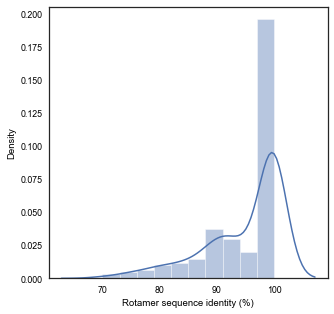

In [28]:
ALL_structure_wise_info_df = pd.read_csv("data/tables/ALL_structure_wise_info.tab", sep="\t", header=0)

rotaseq_id_avg = ALL_structure_wise_info_df['consensus_seq_id%'].describe()["mean"]

annot_rota_df = pd.read_csv("data/tables/ALL_rota.JOY_annot.tab", sep="\t", index_col=None)
rotaalign_df = annot_rota_df[["res_num", "PDB_id", "rota_4"]]
rotaalign_df.columns = ["residue_number", "PDB_id", "rota_4"]
struct_count = len(rotaalign_df.PDB_id.unique())
site_count = rotaalign_df.residue_number.max()

print("The average rotamer sequence identity is %.3f across %d structures and %d sites." % (rotaseq_id_avg, 
                                                                                           struct_count, 
                                                                                           site_count))
fig, ax = plt.subplots(1, figsize=(5,5))
ax = sb.distplot(ALL_structure_wise_info_df['consensus_seq_id%'])
ax.tick_params("both", length=3);
ax.set_xlabel("Rotamer sequence identity (%)", fontsize='medium');
ax.set_ylabel("Density", fontsize='medium');
fig.savefig("figures/rotastate_variability_variability_distplot.pdf", 
            format='pdf', 
            bbox_inches='tight', 
            dpi=fig.dpi)

The average rotamer sequence identity is 95.324 across 204 structures and 257 sites.

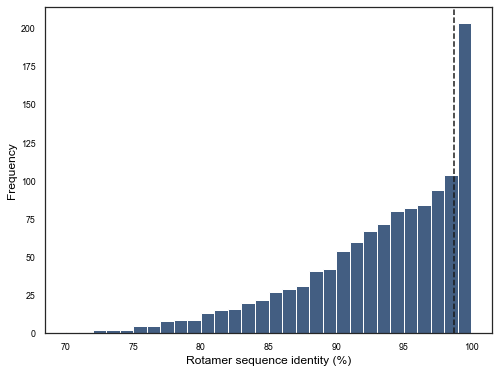

In [29]:
id_median = ALL_structure_wise_info_df['consensus_seq_id%'].median()

fig, ax = plt.subplots(figsize=(8,6))
colors = sb.cubehelix_palette(5, start=.5, 
                              rot=-.7, 
                              light=.97)
ax = ALL_structure_wise_info_df['consensus_seq_id%'].hist(bins=30,
                                                          color=colors[3],
                                                          cumulative=True)
ax.axvline(id_median, linestyle="--", color="k")
# Hide grid lines
ax.grid(False)
ax.set_xlabel("Rotamer sequence identity (%)", fontsize=12);
ax.set_ylabel("Frequency", fontsize=12)
fig.savefig("figures/structure_rotaseq_consensus_seq_id%_cumhist.pdf", format='pdf',
            bbox_inches='tight', dpi=fig.dpi)

### Variability and structure quality


In [31]:
# All Spearman correlations
ALL_structure_wise_info_df = pd.read_csv("data/tables/ALL_structure_wise_info.tab", sep="\t")
corr_df = ALL_structure_wise_info_df[["resolution", "cell_size",
                                      "r_factor", "consensus_seq_id%"]]
corr_df.drop_duplicates(inplace=True)
correlations_data =  ALL_structure_wise_info_df.corr(method="spearman")['consensus_seq_id%'].sort_values()
correlations_data =  correlations_data[["resolution", "cell_size","r_factor"]]
print(correlations_data)
n = len(ALL_structure_wise_info_df.PDB_id.unique())
print("Across %d structures" % (n))

resolution   -0.2582
cell_size    -0.1462
r_factor      0.0279
Name: consensus_seq_id%, dtype: float64
Across 204 structures


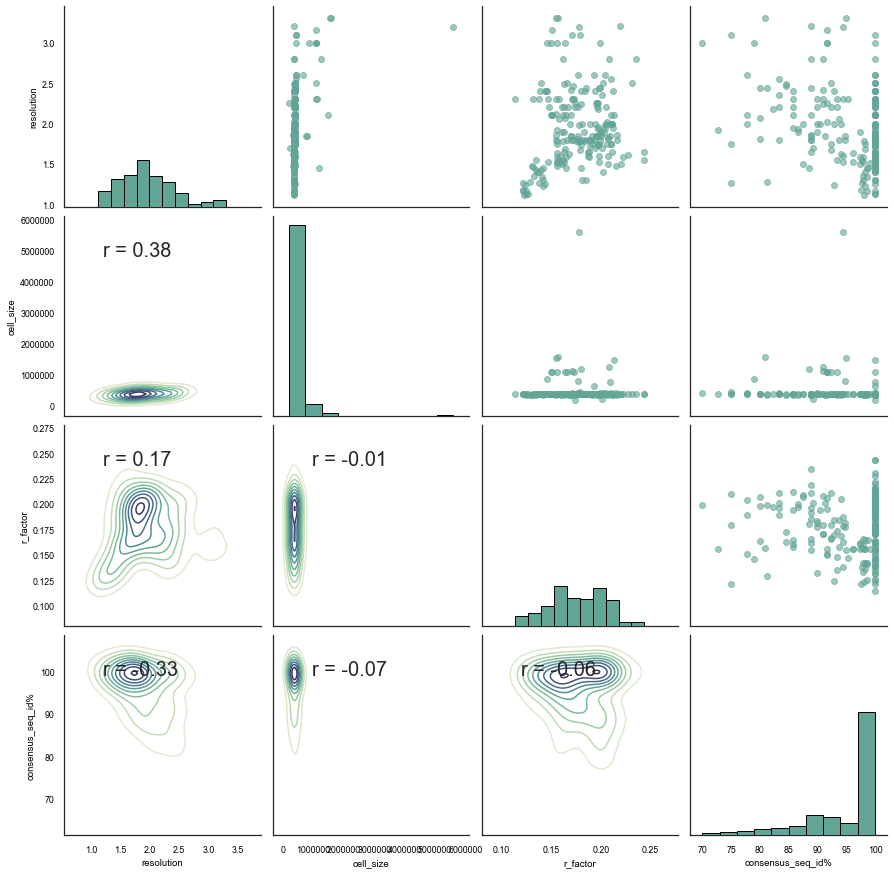

In [32]:
features = pd.read_csv("data/tables/ALL_structure_wise_info.tab", sep="\t")

# Extract the columns to  plot
plot_data = features[["resolution", "cell_size",
                                      "r_factor", "consensus_seq_id%"]]

# Replace the inf with nan
plot_data = plot_data.replace({np.inf: np.nan, -np.inf: np.nan})

# Drop na values
plot_data = plot_data.dropna()

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

c = colors[2]
# Create the pairgrid object
grid = sb.PairGrid(data = plot_data, size = 3);

# Upper is a scatter plot
grid.map_upper(plt.scatter, color = c, alpha = 0.6);

# Diagonal is a histogram
grid.map_diag(plt.hist, color = c, edgecolor = 'black');

# Bottom is correlation and density plot
grid.map_lower(corr_func);
grid.map_lower(sb.kdeplot, cmap = cmap);

fig = grid.fig
figsize = (12, 12)
fig.set_size_inches(figsize)
fig.savefig("figures/rotastate_variability_variability_v_quality_pairplot.pdf", format='pdf', 
            bbox_inches='tight', dpi=fig.dpi)

Cell size, Resolution and R-factor are all positively correlated, although not strongly so. Variability (i.e. consensus_seq_id%) weakly correlates with resolution. Thus rotamer configurations from structures with higher resolutions tend to agree more as one would expect.

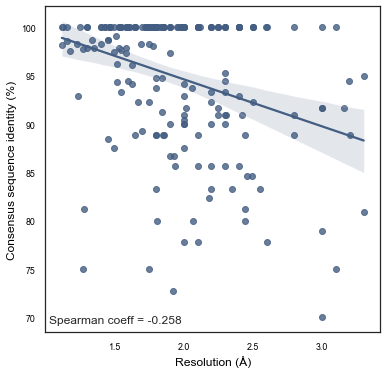

In [33]:
from scipy import stats

fig, ax = plt.subplots(figsize=(6,6))

ALL_structure_wise_info_df = pd.read_csv("data/tables/ALL_structure_wise_info.tab", sep="\t")
coeff, pval = stats.spearmanr(ALL_structure_wise_info_df["resolution"], 
                              ALL_structure_wise_info_df["consensus_seq_id%"])

colors = sb.cubehelix_palette(5, start=.5, rot=-.7, light=.97)

sb.regplot(x="resolution", 
           y="consensus_seq_id%", color=colors[3],
           ax=ax, data=ALL_structure_wise_info_df)

ax.text(.01, .03,'Spearman coeff = %.3f' % (coeff), fontsize=12, transform=ax.transAxes)
ax.set_xlabel("Resolution (Å)", fontsize=12)
ax.set_ylabel("Consensus sequence identity (%)", fontsize=12)
fig.savefig("figures/rotastate_variability.resolution_v_rotaseqid%.regplot.pdf", format='pdf', 
          bbox_inches='tight', dpi=fig.dpi)
plt.show()

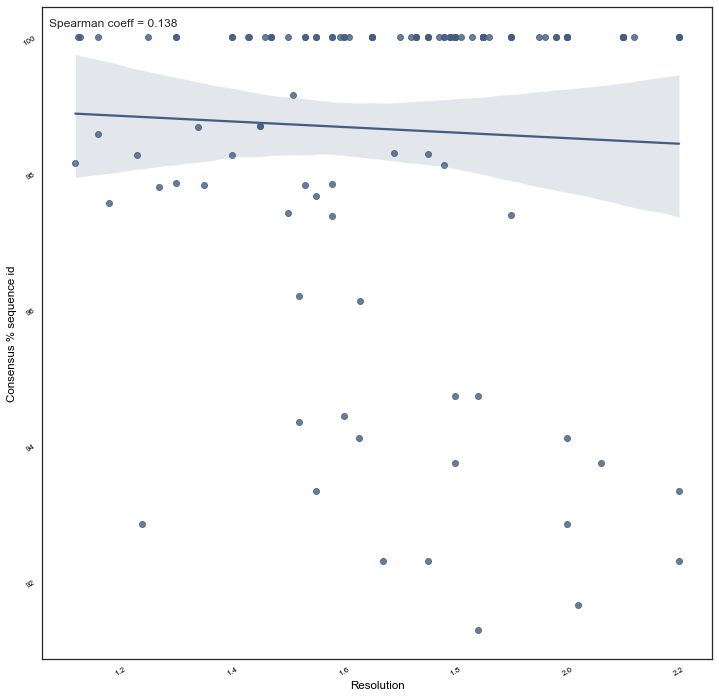

In [34]:
# Removing outliers i.e high-resolution, low rotaseq-id
# doesn't improve correlation.

ALL_structure_wise_info_df = pd.read_csv("data/tables/ALL_structure_wise_info.tab", sep="\t")
df = ALL_structure_wise_info_df.drop_duplicates("PDB_id")
# filter out the structures below 25th percentile 
vc = df["consensus_seq_id%"].quantile(.25)
# filter out the structures above 75th percentile 
vr = df["resolution"].quantile(.75)

df = df[(df["consensus_seq_id%"] > vc) & (df["resolution"] < vr)]

coeff, pval = stats.spearmanr(df["resolution"], 
                              df["consensus_seq_id%"])

colors = sb.cubehelix_palette(5, start=.5, rot=-.7, light=.97)
fig, ax = plt.subplots(1, figsize=(12,12));
sb.regplot(x="resolution", 
           y="consensus_seq_id%", color=colors[3],
           ax=ax, data=df);

ax.text(.01, .97,'Spearman coeff = %.3f' % (coeff), fontsize=12, transform=ax.transAxes);

ax.tick_params("both", labelsize="small", labelrotation=30, length=3);

ax.set_xlabel("Resolution", fontsize="large");
ax.set_ylabel("Consensus % sequence id", fontsize="large");
#fig.savefig("figures/rotastate_variability.acc-ratio_v_variance.regplot.pdf", format='pdf', 
#          bbox_inches='tight', dpi=fig.dpi);
plt.show();
#df["PDB_id"].to_csv("data/tables/no_bottom25_res&consensusid.tab", sep="\t", index=None)

### Variability and RMSD

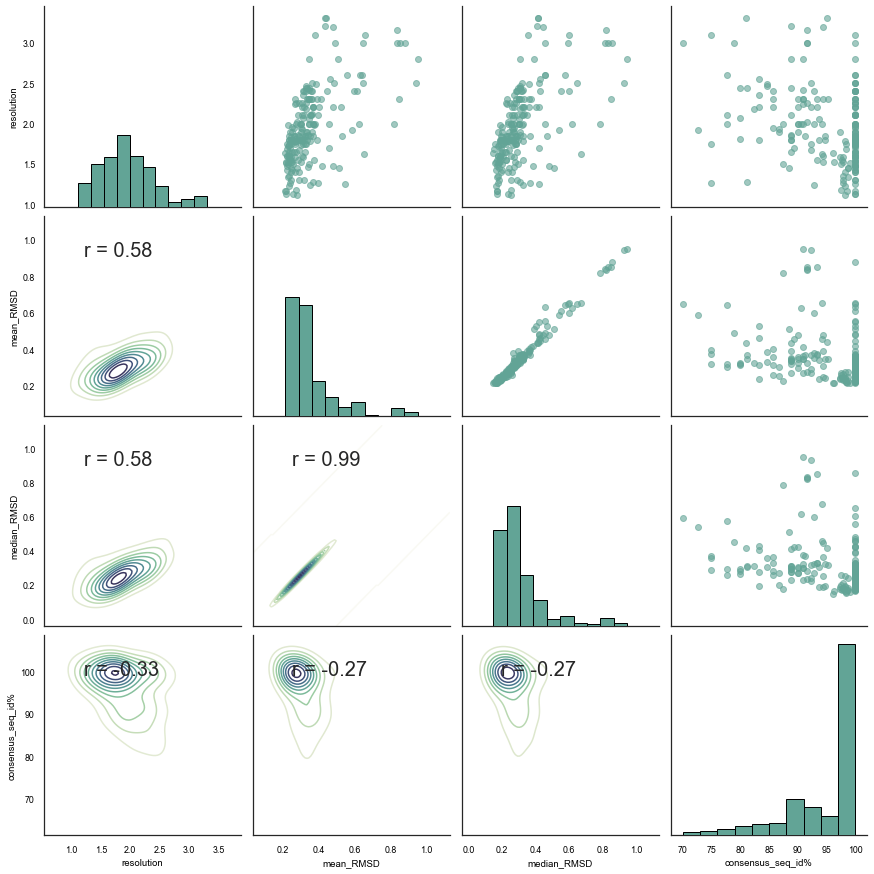

In [36]:
df1 = pd.read_csv("data/tables/ALL_structure_wise_info.tab", sep="\t")
df2 = pd.read_csv("data/tables/rmsd_avg.txt", sep="\t")
features = pd.merge(df1, df2, on="PDB_id")

# Extract the columns to  plot
plot_data = features[["resolution", "mean_RMSD", "median_RMSD", "consensus_seq_id%"]]

# Replace the inf with nan
plot_data = plot_data.replace({np.inf: np.nan, -np.inf: np.nan})

# Drop na values
plot_data = plot_data.dropna()

# calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sb.PairGrid(data = plot_data, size = 3);

# Upper is a scatter plot
c = colors[2]
grid.map_upper(plt.scatter, color = c, alpha = 0.6);

# Diagonal is a histogram
grid.map_diag(plt.hist, color = c, edgecolor = 'black');

# Bottom is correlation and density plot
grid.map_lower(corr_func);
grid.map_lower(sb.kdeplot, cmap = cmap);
plt.show()

b) coeff: -0.3033836809233384 ; pval: 1.0824617131569583e-05
a) coeff: -0.2581850927696304 ; pval: 0.0001927198535528447


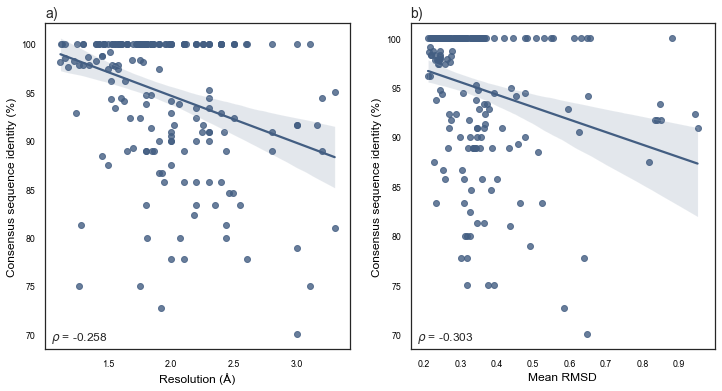

In [71]:
from scipy import stats

df1 = pd.read_csv("data/tables/ALL_structure_wise_info.tab", sep="\t")
df2 = pd.read_csv("data/tables/rmsd_avg.txt", sep="\t")
features = pd.merge(df1, df2, on="PDB_id")


coeff, pval = stats.spearmanr(features["mean_RMSD"],
                              features["consensus_seq_id%"])
print(f"b) coeff: {coeff} ; pval: {pval}")
colors = sb.cubehelix_palette(5, start=.5, rot=-.7, light=.97)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axes

sb.regplot(x="mean_RMSD",
           y="consensus_seq_id%", color=colors[3],
           ax=ax2, data=features)
ax2.text(.02, .03, r'$\rho$ = %.3f' %
         (coeff), fontsize=12, transform=ax2.transAxes)
ax2.set_xlabel("Mean RMSD", fontsize=12)
ax2.set_ylabel("Consensus sequence identity (%)", fontsize=12)
ax2.set_title("b)", loc="left", fontsize=14)
###################################################################################

ALL_structure_wise_info_df = pd.read_csv(
    "data/tables/ALL_structure_wise_info.tab", sep="\t")
coeff, pval = stats.spearmanr(ALL_structure_wise_info_df["resolution"],
                              ALL_structure_wise_info_df["consensus_seq_id%"])
print(f"a) coeff: {coeff} ; pval: {pval}")
sb.regplot(x="resolution",
           y="consensus_seq_id%", color=colors[3],
           ax=ax1, data=ALL_structure_wise_info_df)


ax1.text(.02, .03, r'$\rho$ = %.3f' %
         (coeff), fontsize=12, transform=ax1.transAxes)

ax1.set_xlabel("Resolution (Å)", fontsize=12)
ax1.set_ylabel("Consensus sequence identity (%)", fontsize=12)
ax1.set_title("a)", loc="left", fontsize=14)

fig.savefig("figures/rotastate_variability_resolutionRMSD_v_rotaseqid_regplot.pdf", format='pdf',
            bbox_inches='tight',
            dpi=fig.dpi)

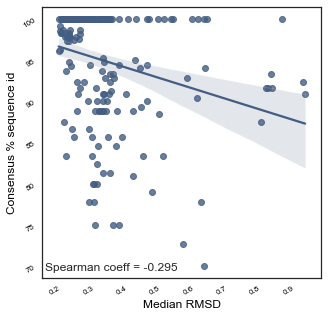

In [38]:
df1 = pd.read_csv("data/tables/ALL_structure_wise_info.tab", sep="\t")
df2 = pd.read_csv("data/tables/rmsd_avg.txt", sep="\t")
features = pd.merge(df1, df2, on="PDB_id")


coeff, pval = stats.spearmanr(features["median_RMSD"], 
                              features["consensus_seq_id%"])

fig, ax = plt.subplots(1, figsize=(5,5))
sb.regplot(x="mean_RMSD", 
           y="consensus_seq_id%", color=colors[3],
           ax=ax, data=features)

ax.text(.01, .03,'Spearman coeff = %.3f' % (coeff), fontsize=12, transform=ax.transAxes)

ax.tick_params("both", labelsize="small", labelrotation=30, length=3)

ax.set_xlabel("Median RMSD", fontsize=12)
ax.set_ylabel("Consensus % sequence id", fontsize=12)
fig.savefig("figures/rotastate_variability.meanRMSD_v_variability.regplot.pdf", format='pdf', 
          bbox_inches='tight', dpi=fig.dpi)
plt.show()

Variability (i.e. consensus_seq_id%) correlates with the average RMSD for a given structure. Thus similar rotasequences correspond to structures that superimpose well.